In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

/home/robaina/Documents/Aquifex/Dokdonia/dokdonia/clusteranalysis.py:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif normalization_file is "auto":


In [ ]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

## Load counts

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


## Apply normalizations to counts

In [3]:
# TPM-normalize count data
patric_file = pd.read_csv(data_dir / "Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv")
tpm = DE.tpmNormalize(counts, patric_file).set_index("index")

In [4]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

INFO:DESeq2:Normalizing counts


In [5]:
# Get transcript/cell dataset
TC = pd.read_csv(data_dir / 'Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC = TC.set_index('index')
TC.index.name = 'ID'

## Find  DE genes

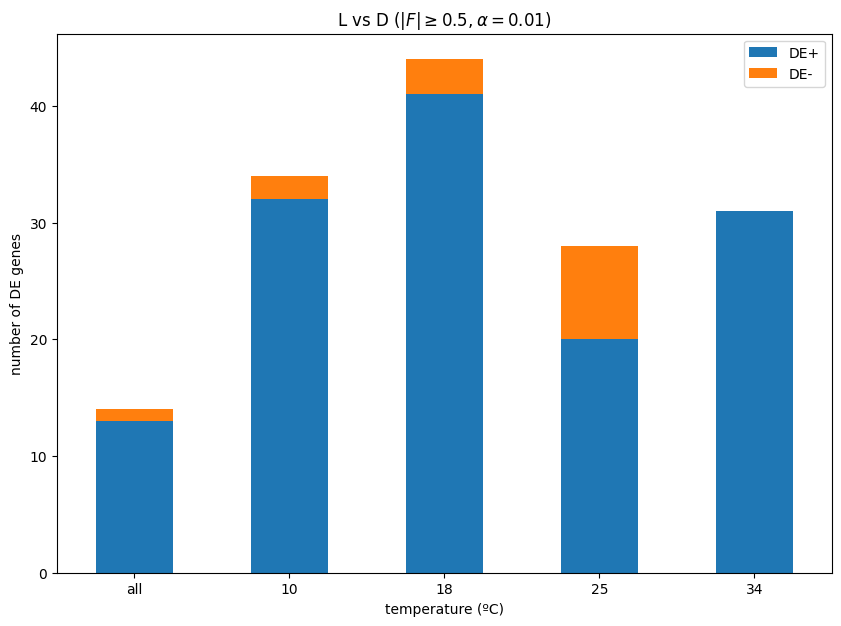

In [6]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [7]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


There are 1930 out of 2877 genes which are DE across all temperature values


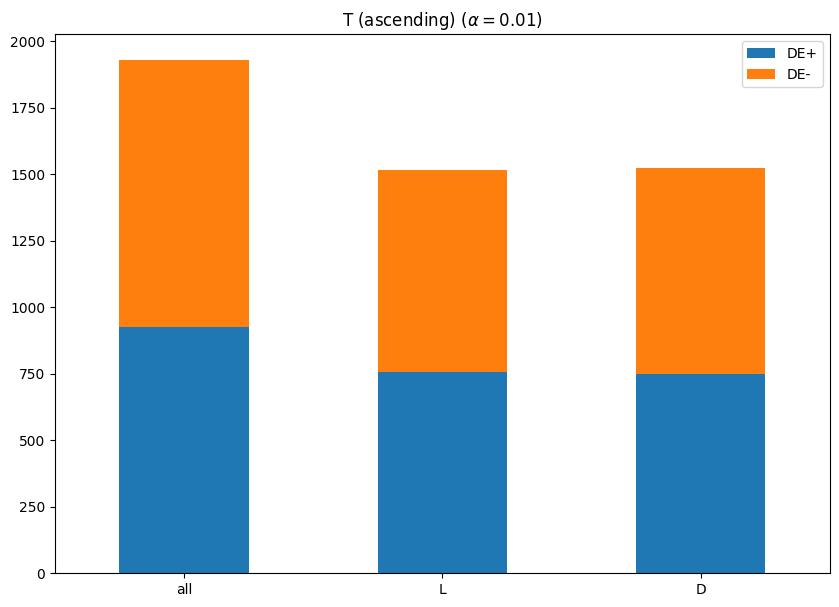

In [8]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

## Remove Light/Dark DE genes from datasets

In [9]:
# Remove light-dark DE genes from TC dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T)) &
    (TC.index.isin(DE_genes_across_T))
    )]

In [10]:
# Remove light-dark DE genes from TPM dataset
tpm_noDE = tpm.loc[(
    (~tpm.index.isin(DE_all_T)) &
    (tpm.index.isin(DE_genes_across_T))
    )]

In [44]:
# Remove light-dark DE genes from DeSeq2-normalized counts
deseq2_counts_noDE = deseq2_counts.loc[(
    (~deseq2_counts.index.isin(DE_all_T)) &
    (deseq2_counts.index.isin(DE_genes_across_T))
    )]

deseq2_counts = deseq2_counts.drop("index", axis=1)
deseq2_counts_noDE = deseq2_counts_noDE.drop("index", axis=1)

In [25]:
# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) &
    (counts["index"].isin(DE_genes_across_T))
    )]

## Plot data summaries

Text(0, 0.5, 'Total counts')

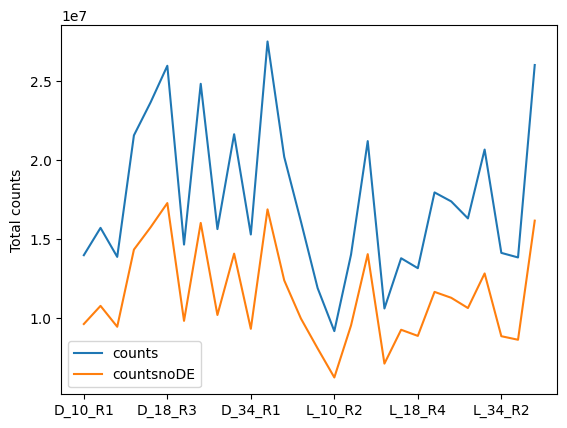

In [28]:
# Total counts sum per sample
ax = pd.concat((counts.set_index("index").sum(),counts_noDE.set_index("index").sum()), axis=1).rename({0: "counts", 1: "countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total counts")

Text(0, 0.5, 'Total TC')

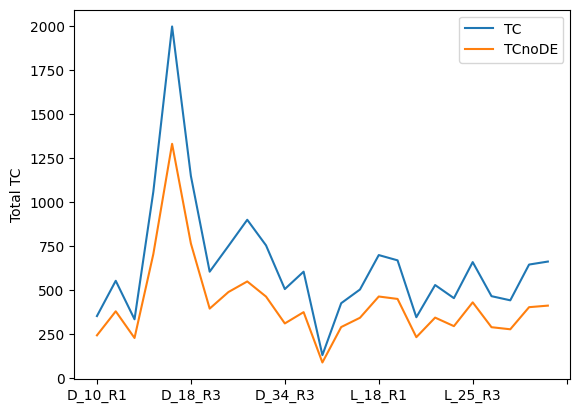

In [29]:
# Total TC sum per sample
ax = pd.concat((TC.sum(), TCnoDE.sum()), axis=1).rename({0: "TC", 1: "TCnoDE"}, axis=1).plot()
ax.set_ylabel("Total TC")

Text(0, 0.5, 'Total TPM')

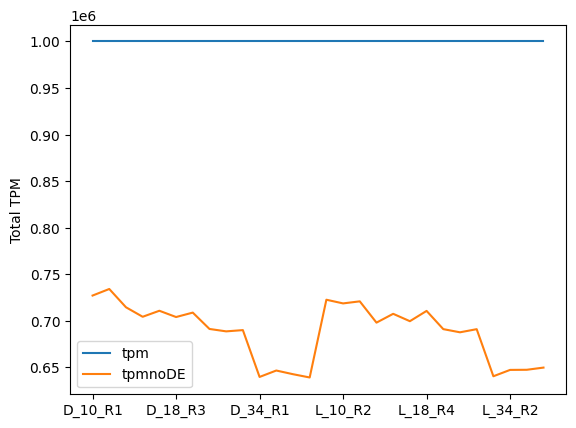

In [30]:
# Total TPM sum per sample
ax = pd.concat((tpm.sum(axis=0),tpm_noDE.sum(axis=0)), axis=1).rename({0: "tpm", 1: "tpmnoDE"}, axis=1).plot()
ax.set_ylabel("Total TPM")

Text(0, 0.5, 'Total deseq2 counts')

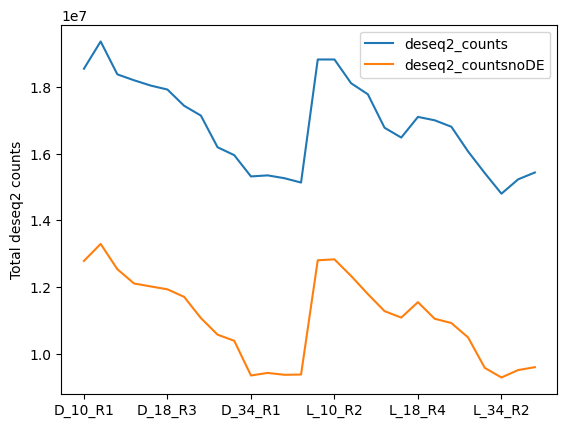

In [45]:
# Total deseq2 counts sum per sample
ax = pd.concat((deseq2_counts.sum(axis=0),deseq2_counts_noDE.sum(axis=0)), axis=1).rename({0: "deseq2_counts", 1: "deseq2_countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total deseq2 counts")

## Find Clusters for TC and TPM

### Transcript / Cell


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 17 April 2023 (17:16:56)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

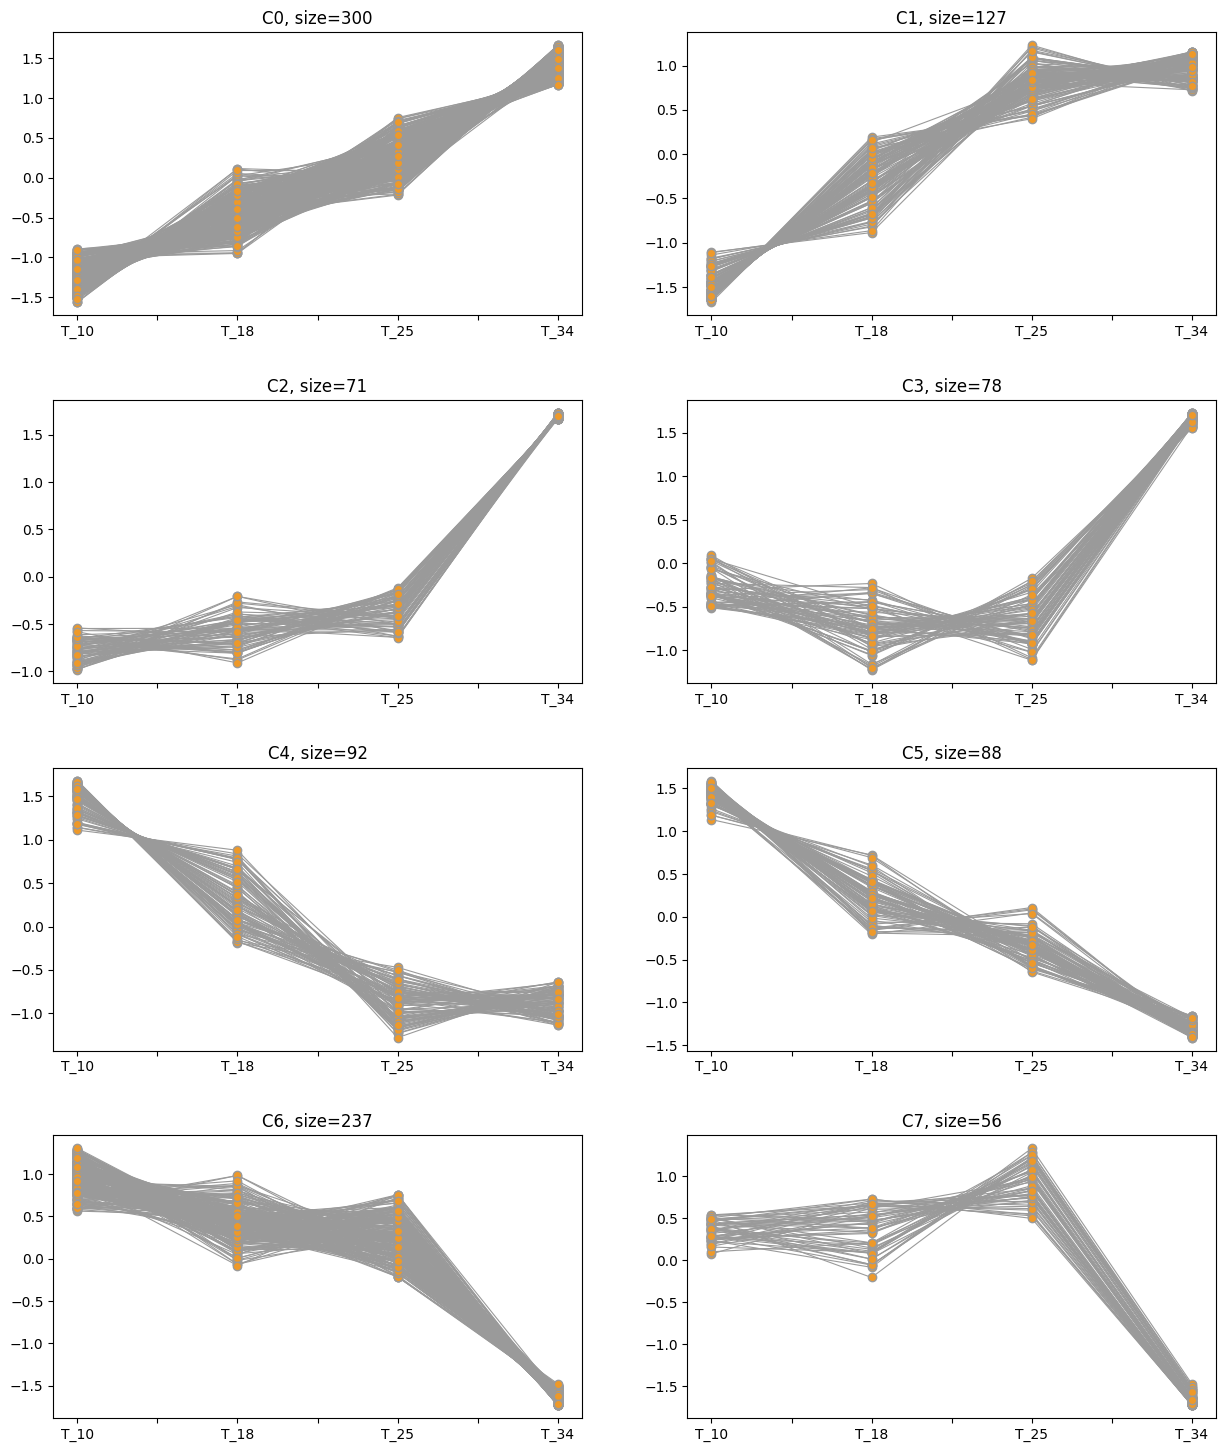

In [39]:
# Using Transcripts/cell
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TC = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1e2)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters_TC)

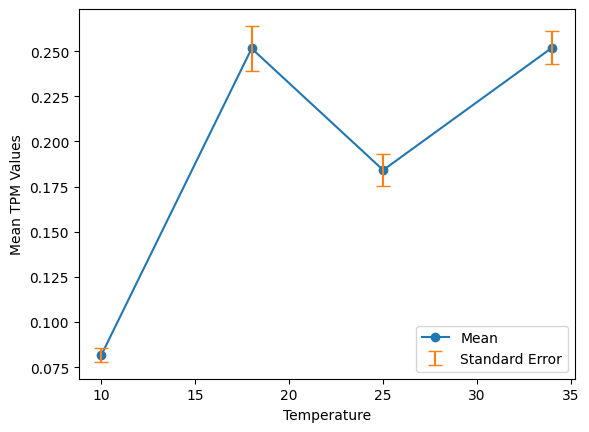

In [40]:
temperatures = [10, 18, 25, 34]
marker_genes = [gene for gene in clusters_TC["C0"]]
df = TCnoDE.loc[marker_genes, :]


df_long = df.melt(var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

grouped = df_long.groupby('Temperature')['Value']
mean_values = grouped.mean()
standard_error_values = grouped.sem()


fig, ax = plt.subplots()

# Plot the mean values
ax.plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

# Add error bars for the standard errors
ax.errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Mean TPM Values')
# ax.set_title('Mean Values with Standard Error across Temperature Values')
ax.legend()

# Show the plot
plt.show()

# TPM


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 17 April 2023 (17:19:01)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

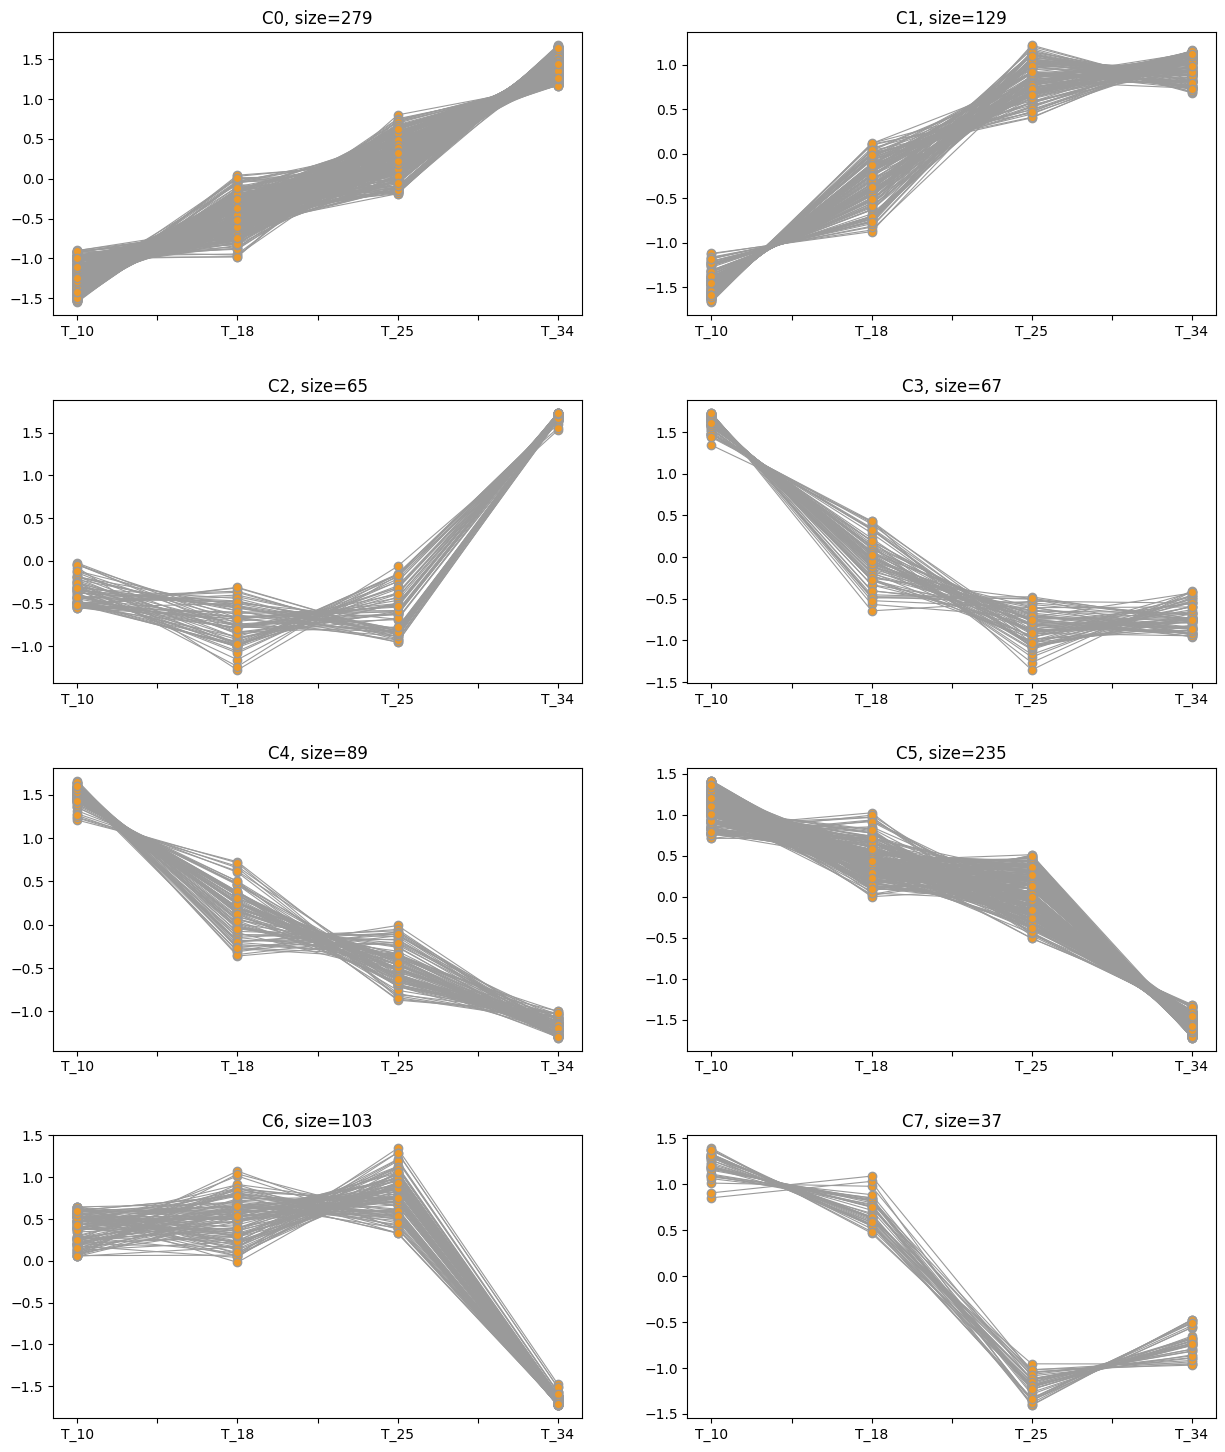

In [41]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TPM'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TPM = CA.getGeneClusters(tpm_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1e4)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters_TPM)

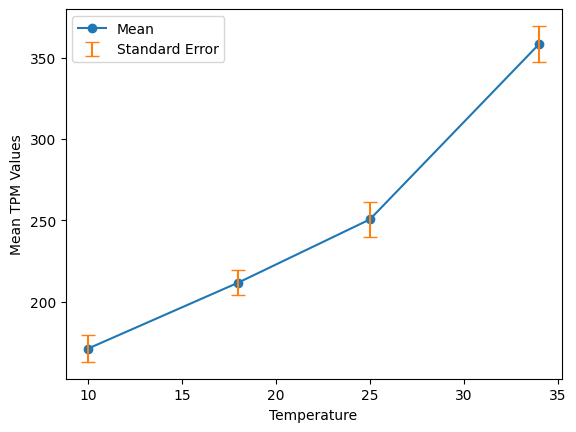

In [42]:
temperatures = [10, 18, 25, 34]
marker_genes = [gene for gene in clusters_TPM["C0"]]
df = tpm_noDE.loc[marker_genes, :]


df_long = df.melt(var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

grouped = df_long.groupby('Temperature')['Value']
mean_values = grouped.mean()
standard_error_values = grouped.sem()


fig, ax = plt.subplots()

# Plot the mean values
ax.plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

# Add error bars for the standard errors
ax.errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Mean TPM Values')
# ax.set_title('Mean Values with Standard Error across Temperature Values')
ax.legend()

# Show the plot
plt.show()

### Deseq2


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 17 April 2023 (17:22:33)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

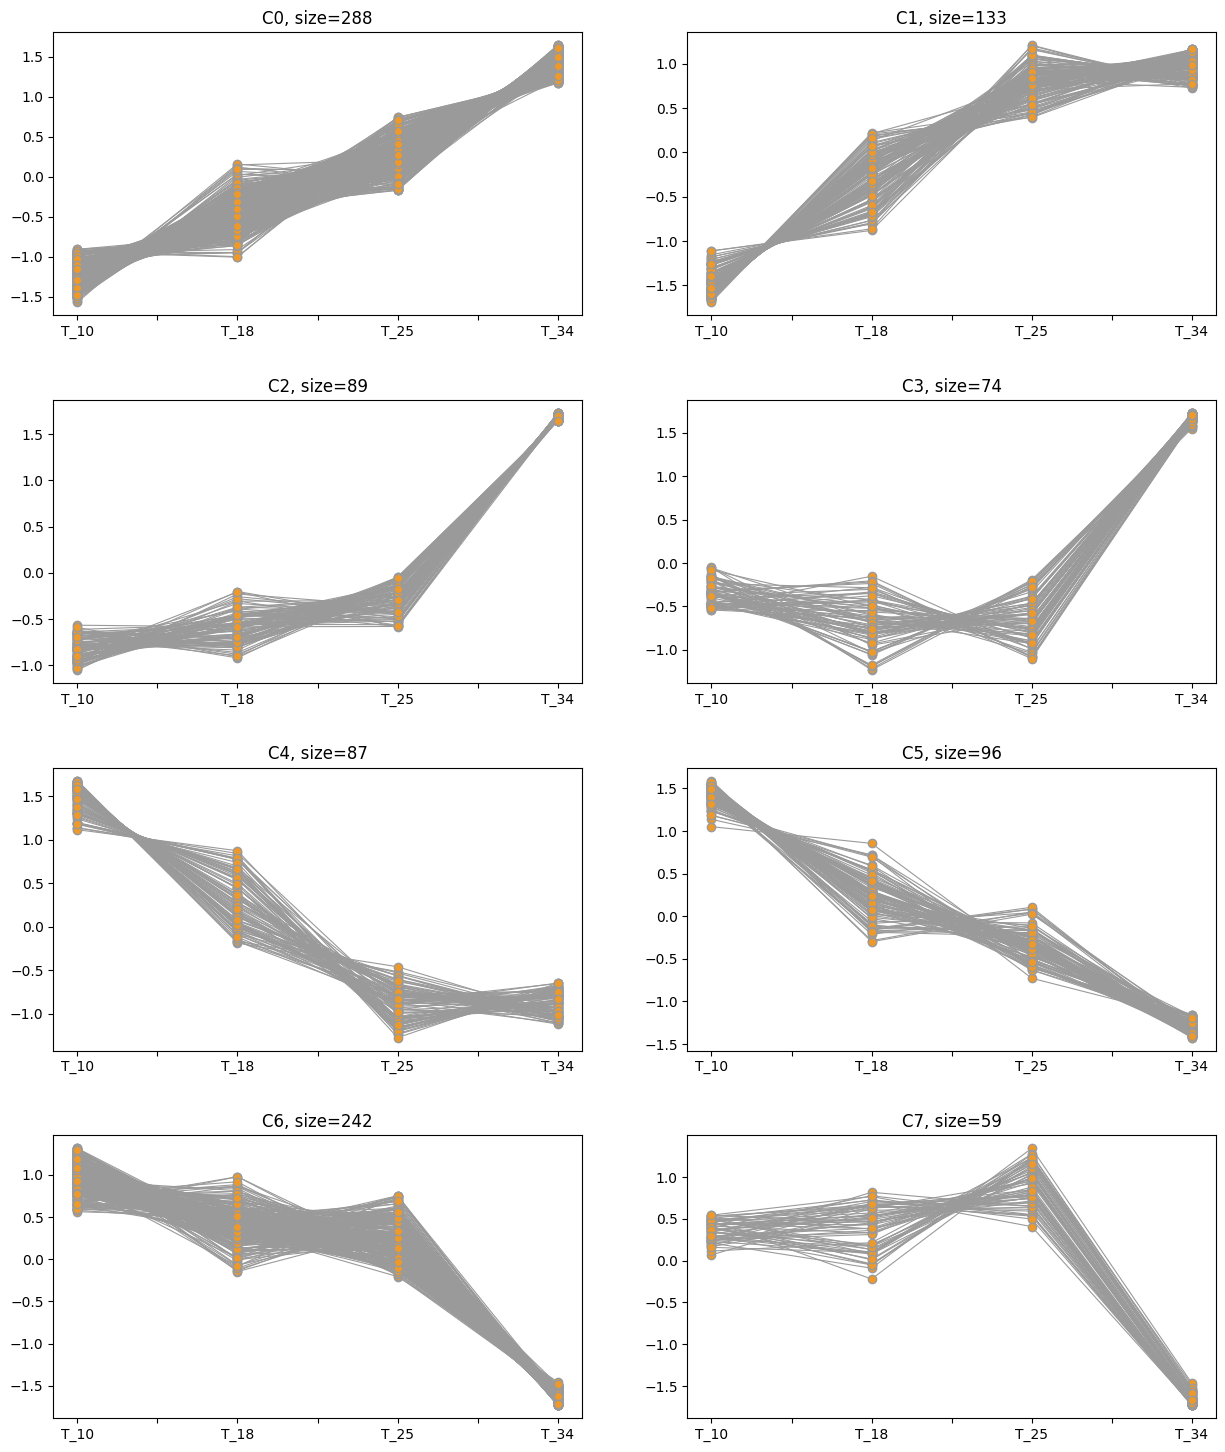

In [48]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_DS2 = CA.getGeneClusters(deseq2_counts_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file="clust_normalization.txt",
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters_DS2)

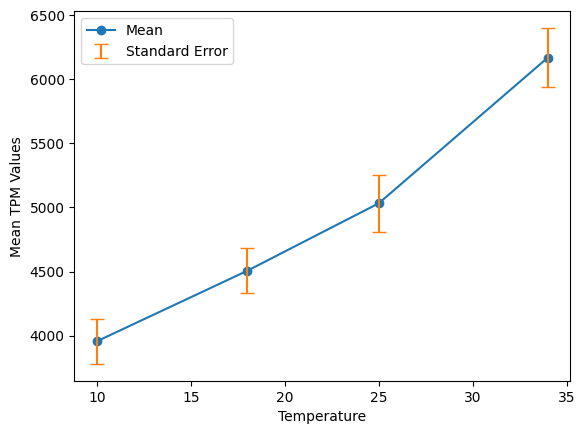

In [49]:
temperatures = [10, 18, 25, 34]
marker_genes = [gene for gene in clusters_DS2["C0"]]
df = deseq2_counts_noDE.loc[marker_genes, :]


df_long = df.melt(var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

grouped = df_long.groupby('Temperature')['Value']
mean_values = grouped.mean()
standard_error_values = grouped.sem()


fig, ax = plt.subplots()

# Plot the mean values
ax.plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

# Add error bars for the standard errors
ax.errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Mean TPM Values')
# ax.set_title('Mean Values with Standard Error across Temperature Values')
ax.legend()

# Show the plot
plt.show()